# Person Segmentation Netowork

### Import necessary python lib

- set ImageFile.LOAD_TRUNCATED_IMAGES = True to avoid warinings while training. 
- data module contains all the image generator module functions for training

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import segmentation_models as sm
import sys
sys.path.append("..")
from seg_net.data import *
import keras

Using TensorFlow backend.
/home/avantariml/.local/lib/python3.5/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


## Set Model Params

In [1]:
INPUT_SHAPE =  (512,512,3) #(768,768,3) (512,512,3)
NUM_CLASS = 1
BACKBONE = 'mobilenetv2'
MODEL_NAME = 'Unet'
LOSS_METRICS = 'BCE_ACC_IOU'
MODEL_PATH = '/media/new_hdd2/seg_net/results/Models/Models'
ACTIVATION = 'sigmoid'

model_fname = '{0}_{1}_{2}_{3}_{4}_{5}'.format(BACKBONE,
                                              MODEL_NAME,
                                              LOSS_METRICS,
                                              NUM_CLASS,
                                              ACTIVATION,
                                              INPUT_SHAPE[0])
keras_filename = '{}.hdf5'.format(model_fname)

## Build Model

In [4]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                  classes=NUM_CLASS,
                  activation=ACTIVATION,
                  input_shape = INPUT_SHAPE)

Instructions for updating:
Colocations handled automatically by placer.


/home/avantariml/.local/lib/python3.5/site-packages/segmentation_models/backbones/mobilenetv2.py:273: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [5]:
model.compile('sgd', loss=sm.losses.bce_dice_loss, metrics=['accuracy',sm.metrics.iou_score])
#model.compile('Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile('sgd', loss='mean_squared_error', metrics=['accuracy',sm.metrics.iou_score])

In [6]:
model.load_weights(os.path.join(MODEL_PATH,keras_filename))

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Create Train and validation Image generators , keras callbacks to save model, learning rate scheduler and tensorboard monitoring.

In [19]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(1,'../data/raw/train_person','images','annotations',
                        data_gen_args,save_to_dir = None,
                        target_size = INPUT_SHAPE[:2],
                        imgNorm="divide" , 
                        binary = True,
                        num_class = NUM_CLASS, 
                        multiclass = False)

'''valGene = validationGenerator(1,'../data/raw/val','images','annotations',
                                save_to_dir = None,
                                target_size = INPUT_SHAPE[:2],
                                imgNorm="divide" , 
                                binary = False,
                                num_class = NUM_CLASS, 
                                multiclass = False)'''

model_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODEL_PATH,keras_filename), 
                                                   monitor='loss',
                                                   verbose=1, 
                                                   save_best_only=True)

#tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=0, write_graph=True, write_images=True)

lr_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)

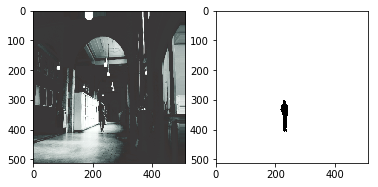

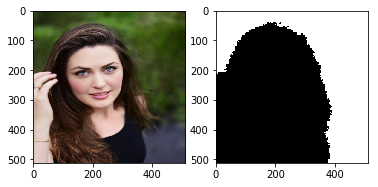

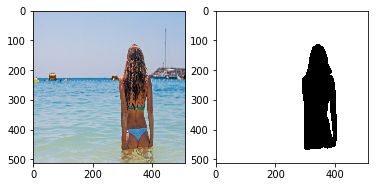

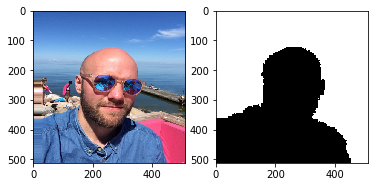

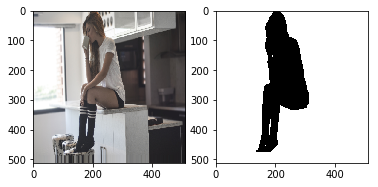

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(5):
    inp,otp = next(myGene)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(inp[0,:,:,:])
    #axarr[1].imshow(otp.argmax(axis=-1)[0,:,:], cmap='Greys',  interpolation='nearest')
    axarr[1].imshow(np.squeeze(otp[0]), cmap='Greys',  interpolation='nearest')

## Train Model

In [20]:
model.fit_generator(myGene,steps_per_epoch=3000,epochs=50,
                    #validation_data=valGene, validation_steps=100,
                    callbacks=[model_checkpoint,lr_cb],
                    initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
Found 7314 images belonging to 1 classes.
Found 7314 images belonging to 1 classes.
3000/3000 [==============================] - 367s 122ms/step - loss: 0.1121 - acc: 0.9788 - iou_score: 0.9123

Epoch 00001: loss improved from inf to 0.11212, saving model to /media/new_hdd2/seg_net/results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512s.hdf5
Epoch 2/50
3000/3000 [==============================] - 355s 118ms/step - loss: 0.1134 - acc: 0.9781 - iou_score: 0.9115

Epoch 00002: loss did not improve from 0.11212
Epoch 3/50
3000/3000 [==============================] - 368s 123ms/step - loss: 0.1598 - acc: 0.9695 - iou_score: 0.8789

Epoch 00003: loss did not improve from 0.11212
Epoch 4/50
3000/3000 [==============================] - 374s 125ms/step - loss: 0.1292 - acc: 0.9761 - iou_score: 0.8962

Epoch 00004: loss did not improve from 0.11212
Epoch 5/50
3000/3000 [==============================] - 361s 120ms/step - loss: 

Epoch 34/50
3000/3000 [==============================] - 365s 122ms/step - loss: 0.0663 - acc: 0.9882 - iou_score: 0.9400

Epoch 00034: loss did not improve from 0.06437
Epoch 35/50
3000/3000 [==============================] - 346s 115ms/step - loss: 0.0635 - acc: 0.9882 - iou_score: 0.9438

Epoch 00035: loss improved from 0.06437 to 0.06348, saving model to /media/new_hdd2/seg_net/results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512s.hdf5
Epoch 36/50
3000/3000 [==============================] - 373s 124ms/step - loss: 0.0630 - acc: 0.9884 - iou_score: 0.9439

Epoch 00036: loss improved from 0.06348 to 0.06295, saving model to /media/new_hdd2/seg_net/results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512s.hdf5
Epoch 37/50
3000/3000 [==============================] - 368s 123ms/step - loss: 0.0640 - acc: 0.9883 - iou_score: 0.9425

Epoch 00037: loss did not improve from 0.06295
Epoch 38/50
3000/3000 [==============================] - 357s 119ms/step - loss: 0.0620 

## Test Model

In [21]:
import skimage
import glob
import os
import numpy as np
from keras.preprocessing import image
import cv2
path = "../data/raw/test"
fnames = sorted(glob.glob(os.path.join(path,"*.jpg")))
images = []
outs = []
for f in fnames:
    img = skimage.io.imread(f)
    img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
    img_ = preprocess_input(img_, imgNorm="divide")
    images.append(img)
    #outs.append(np.squeeze(model.predict(img_)).argmax(axis=-1))
    outs.append(np.squeeze(model.predict(img_)))

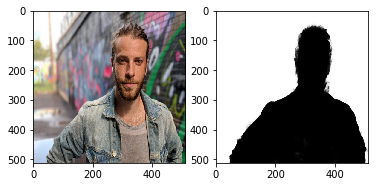

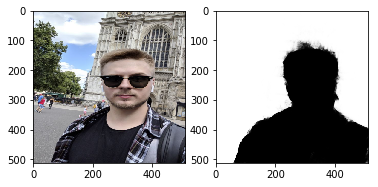

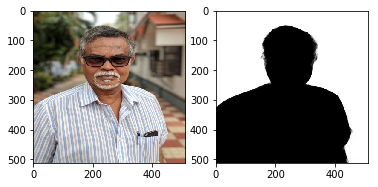

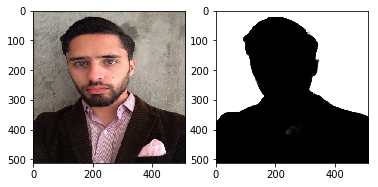

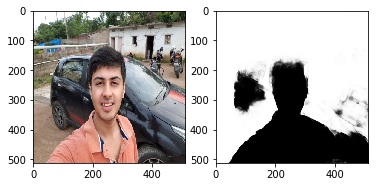

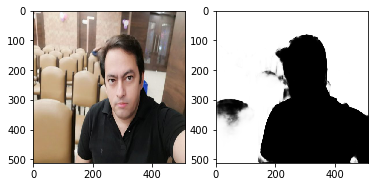

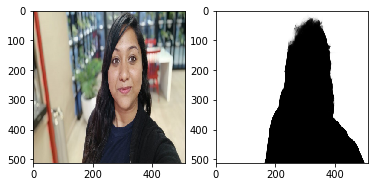

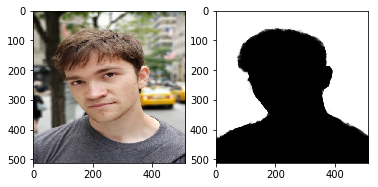

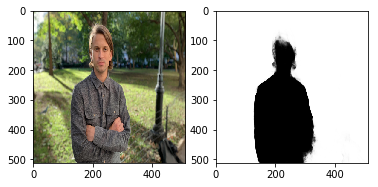

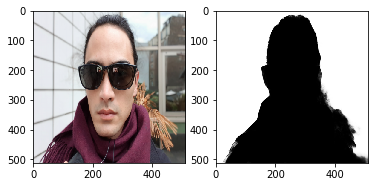

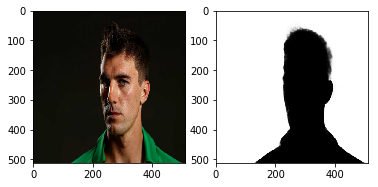

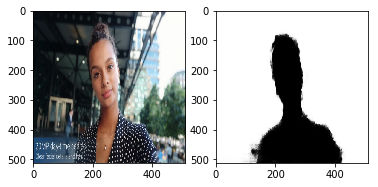

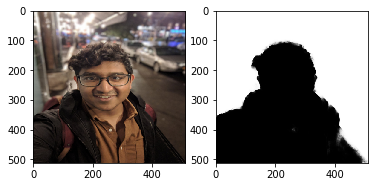

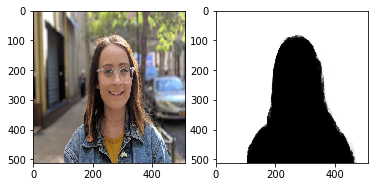

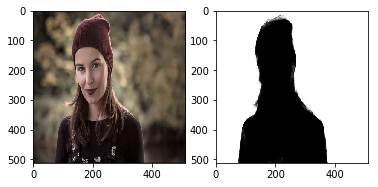

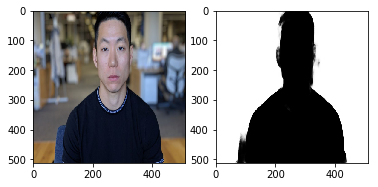

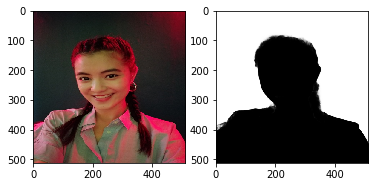

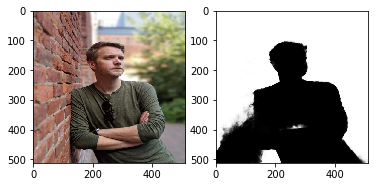

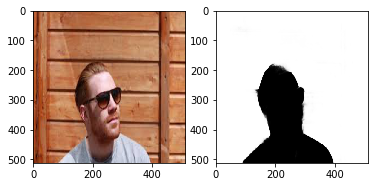

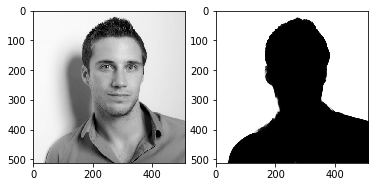

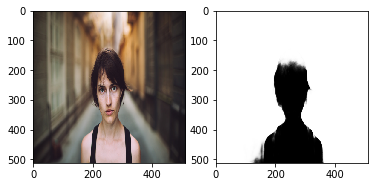

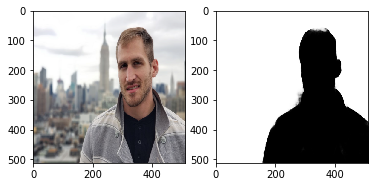

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
for inp,otp in zip(images,outs):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(skimage.transform.resize(inp,otp.shape,anti_aliasing=True))
    #otp[otp>0.3]=1
    axarr[1].imshow(otp*255, cmap='Greys',  interpolation='nearest')

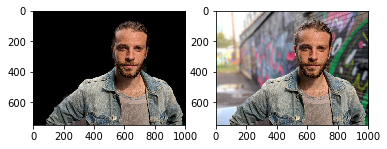

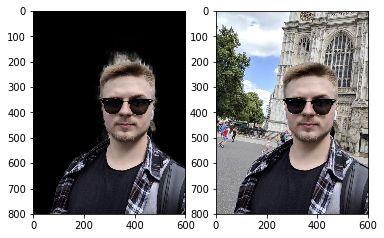

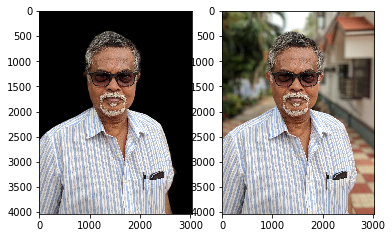

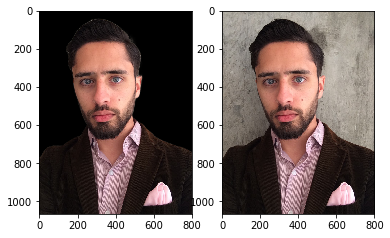

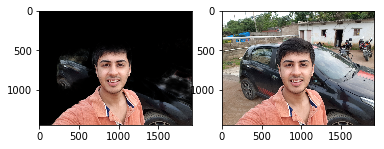

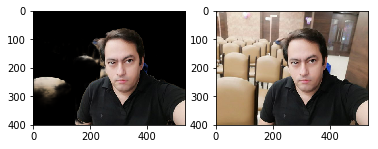

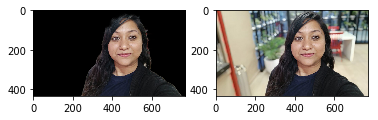

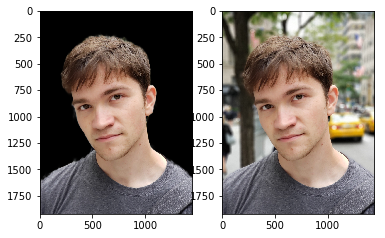

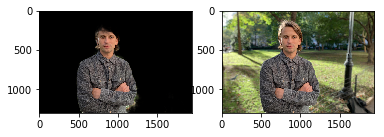

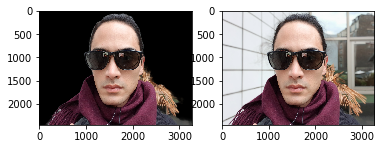

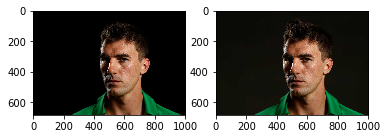

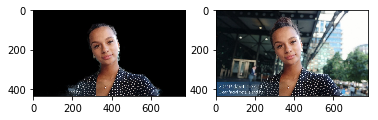

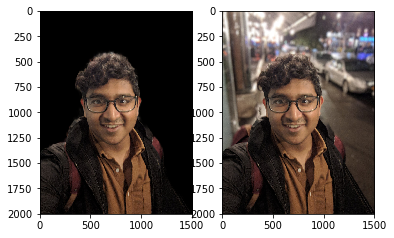

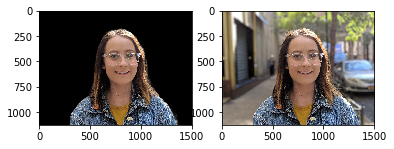

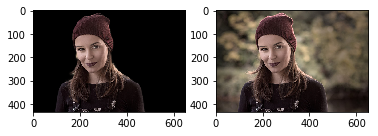

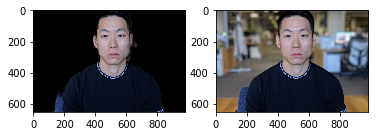

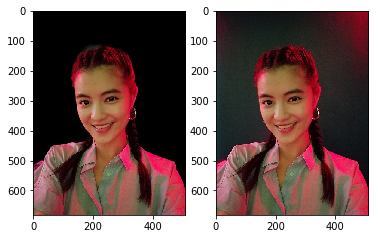

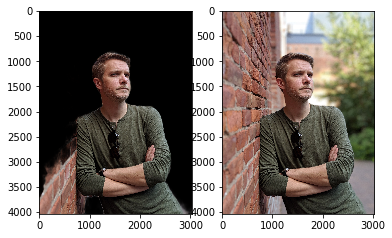

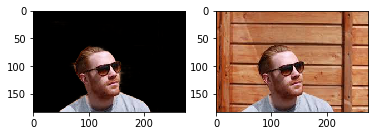

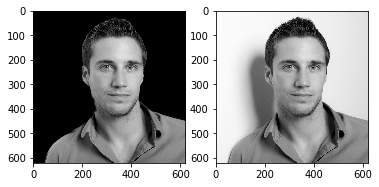

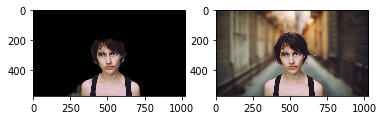

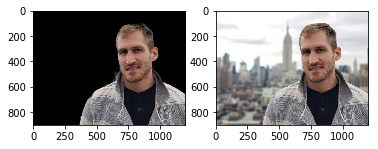

In [24]:
for inp,otp in zip(images,outs):
    mask = skimage.transform.resize(otp,inp.shape[:2],preserve_range=True)
    #mask = cv2.resize(otp,inp.shape[:2])
    im = np.copy(inp)
    #mask[mask>0.3]=1
    #im[mask==0]=0
    im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(im)
    axarr[1].imshow(inp)

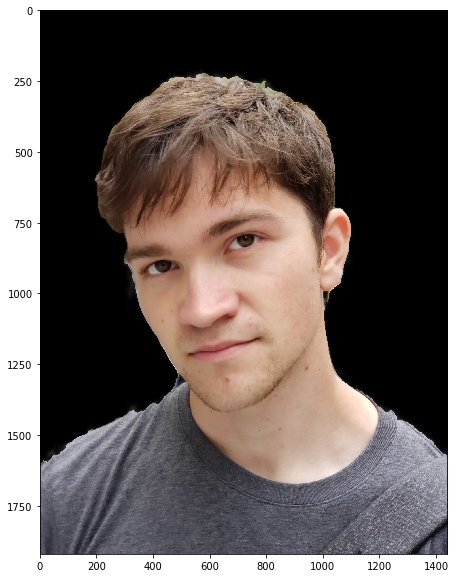

In [30]:
import random
i = random.choice(range(0,len(fnames)))
im = np.copy(images[i])
mask = skimage.transform.resize(outs[i],im.shape[:2],preserve_range=True)
mask[mask>0.3]=1
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
#im[mask<0.3]=0
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(im)